ENSEMBLE LEARNNG AND RANDOM FOREST

In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

#for plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#save the figures

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Voting Classifiers 

In [2]:
head_proba = .51 #coin toss probability of getting heads
coin_tosses = (np.random.rand(10000, 10) < head_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Law of large numbers

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [9]:
#find out each classifier's accuracy 
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Ideally, Soft voting should achieve an even better performance than hard voting.
If the code above is run on soft voting, this can be proved 

Bagging and Pasting

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples = 100, bootstrap = True, n_jobs = -1, random_state = 42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

. The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions
(–1 tells Scikit-Learn to use all available cores)


In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [13]:
#Generate a single decsision tree vs a bagging ensemble of 500 trees
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


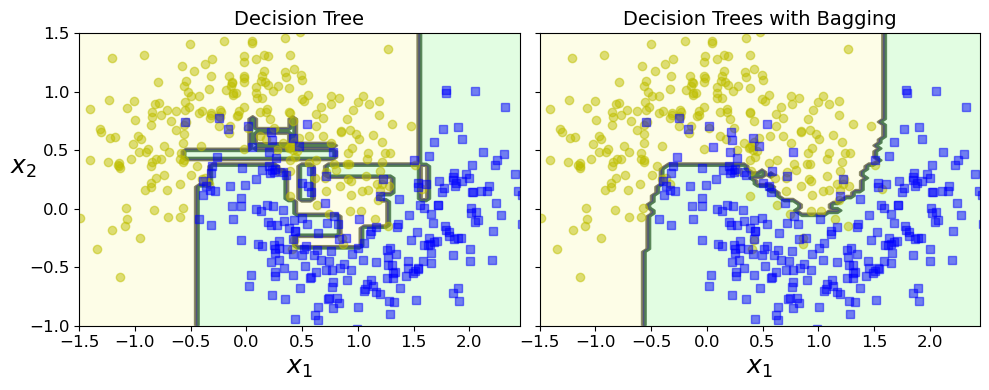

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

bagging classifier automatically performs soft voting if the base clf can estimate class probabilities (if it has a predict_proba() method), which is the case with Decision Tree classifier 

Out of bag evaluation

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap = True, oob_score = True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

In [16]:
bag_clf.oob_decision_function_ 

array([[0.43428571, 0.56571429],
       [0.40782123, 0.59217877],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.05699482, 0.94300518],
       [0.3575419 , 0.6424581 ],
       [0.00534759, 0.99465241],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.76470588, 0.23529412],
       [0.00549451, 0.99450549],
       [0.80851064, 0.19148936],
       [0.81443299, 0.18556701],
       [0.95906433, 0.04093567],
       [0.04891304, 0.95108696],
       [0.00561798, 0.99438202],
       [0.98984772, 0.01015228],
       [0.96      , 0.04      ],
       [0.98989899, 0.01010101],
       [0.01117318, 0.98882682],
       [0.32984293, 0.67015707],
       [0.91160221, 0.08839779],
       [1.        , 0.        ],
       [0.97740113, 0.02259887],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.65608466, 0.34391534],
       [0.

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Random Forests

In [19]:
from sklearn.ensemble import RandomForestClassifier 

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

A random forest is equivalent to a bag of decision trees:

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter= 'random', max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
np.sum(y_pred == y_pred_rf)/len(y_pred)         #very similar predictions

0.976

Feature Importance

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)


sepal length (cm) 0.09722245530652125
sepal width (cm) 0.024302619474264094
petal length (cm) 0.4222416078021094
petal width (cm) 0.4562333174171053


. It seems that the most important features are the
petal length (42%) and width (45%), while sepal length and width are rather unimportant in comparison (9.7% and 2%, respectively).

Boosting

AdaBoost 

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm= 'SAMME.R', learning_rate=0.5, random_state=42
)

In [25]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

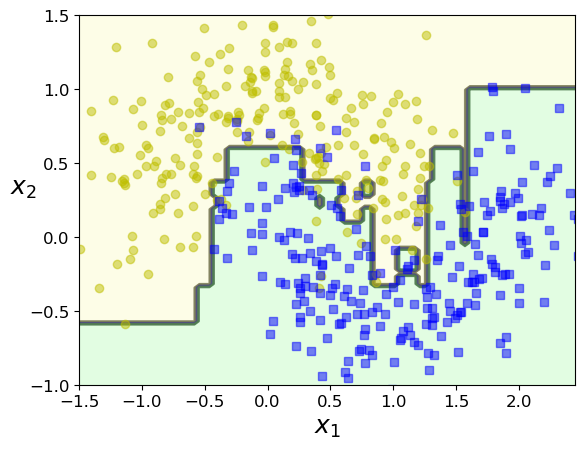

In [26]:
plot_decision_boundary(ada_clf, X, y)

If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.

Gradient boosting

In [27]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [28]:
#Now train a second DecisionTreeRegressor on the residual errors made by the first predictor:

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [29]:
#train a third DecisionTreeRegressor on the residual errors made by the second predictor:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [31]:
X_new = np.array([[0.8]])

In [33]:
#the ensemble predictions are the sum of the individual predictions
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([ 0.7658906 , -0.06976324,  0.85124217,  0.1015663 ,  0.1015663 ,
        0.85124217,  0.7658906 ,  0.1015663 ,  0.1015663 ,  1.0457984 ,
        0.56489706,  0.7362266 ,  1.0457984 ,  0.1015663 ,  1.0457984 ,
        0.85124217,  0.89856769, -0.06976324,  0.85124217,  0.96044684,
        0.89856769,  1.19073666,  0.7362266 ,  0.7658906 ,  0.1015663 ,
        1.19073666,  0.89856769,  0.1015663 ,  0.1015663 ,  1.02257171,
        0.89856769,  0.93722015,  0.89856769,  0.1015663 , -0.06976324,
        1.02257171,  0.85124217, -0.06976324,  0.1015663 , -0.06976324,
        1.0457984 ,  0.1015663 ,  1.19073666, -0.1231484 ,  0.56489706,
       -0.06976324,  0.56489706, -0.06976324,  0.85124217,  0.56489706,
        0.1015663 ,  0.1015663 ,  0.1015663 ,  0.7658906 ,  0.1015663 ,
        0.1015663 ,  0.1015663 ,  0.56489706,  0.1015663 ,  0.1015663 ,
        0.89856769,  0.7362266 ,  0.93722015,  0.96044684,  0.1015663 ,
       -0.06976324,  0.89856769,  0.1015663 , -0.1231484 ,  0.85